In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB :
  %load_ext autoreload
  %autoreload 2
  
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/Github


  repository= 'keyword_spotting'
  %cd {repository}
  %ls -a
  # CPU:
  #!pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

  # GPU:
  !pip install pydub torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0 -f https://download.pytorch.org/whl/torch_stable.html
    
    

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio,torchvision
import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm import tqdm
import metrics.metrics as metrics
from dataset.subsetSC import SubsetSC
from models.spectrogram_model import spectrogram_model
from utilsFunc import *
import numpy as np

working_dir=%pwd
if 'PROJET_ESSAI/notebooks' in working_dir :
    print('Wrong working directory')
    %cd ..
    working_dir=%pwd
    print('New directory :',working_dir)

if 'storage' not in locals():   
    storage=dict()

Wrong working directory
/Users/carlos/Documents/LeTaffe/PROJET_ESSAI
New directory : /Users/carlos/Documents/LeTaffe/PROJET_ESSAI


In [3]:
storage['device'] = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using',storage['device'])

Using cpu


## Downloading and setting up the dataset

In [3]:
with timeThat('training & test sets'):
    root='/content/sample_data' if IN_COLAB else './'
    if 'test_set' not in locals():
        test_set = SubsetSC("testing",root)
storage['waveform'], storage['sample_rate'], label, speaker_id, utterance_number = test_set[0]

# TODO : We are doing it without resampling it.
#resample_transform=torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=new_sample_rate)

training & test sets finished in  0:00:10.763955


## Let's visualize the data !

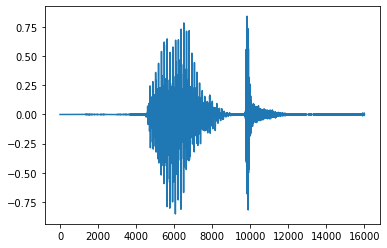

In [4]:
plt.plot(storage['waveform'].t().numpy())

In [ ]:
def pdm(x):
    n = len(x)
    y = np.zeros(n)
    error = np.ones(n+1)    
    for i in range(n):
        y[i] = 1 if x[i] >= error[i] else 0
        error[i+1] = y[i] - x[i] + error[i]
    return y, error[:n]

def get_pdm_samples(samples, pdm_factor):
    n_pdm_samples = int(np.round(len(samples) * pdm_factor))
    M5_transform = torchaudio.transforms.Resample(orig_freq=storage['sample_rate'], new_freq=n_pdm_samples)
    upsampled_samples = M5_transform(samples)
    #upsampled_samples = resample(samples, n_pdm_samples)
    pdm_samples, pdm_error = pdm(upsampled_samples)
    return pdm_samples, upsampled_samples

In [ ]:
pdm_sample_rate

In [ ]:
samples=storage['waveform'][0]
#normalisation :
normalisation=False
if normalisation :
    samples -= torch.min(samples)
    samples /= torch.max(samples)

duration=len(samples) / storage['sample_rate']


pdm_factor = 48
pdm_sample_rate = storage['sample_rate'] * pdm_factor
pdm_samples, upsampled_samples = get_pdm_samples(samples, pdm_factor)

fig, axes = plt.subplots(4, 1, figsize=(15, 12), gridspec_kw=dict(hspace=0.1),
                         sharex=True)

ts = np.linspace(0, duration, len(samples))
axes[0].plot(ts, samples,label='original sample')
axes[0].legend()
ts = np.linspace(0, duration, len(upsampled_samples))
axes[1].plot(ts, upsampled_samples,label= 'upsampled signal')

indexes = np.where(pdm_samples)[0]
axes[1].scatter(ts[indexes], np.ones(len(indexes))+0.1, s=1,label='PDM sample')
axes[1].legend()

axes[2].hist(ts[indexes], range=(0, duration), bins=4096, density=True,label='PDM density')
axes[2].legend()

diffs = np.diff(ts[indexes])
ts = np.linspace(0, duration, len(diffs))
axes[3].plot(ts, diffs)

print(1/np.min(diffs))

#axes[3].set_ylim(0, 0.00002)
#axes[3].set_xlim(0.6, 0.601)
axes[3].set_xlim(0.2, 0.8)


plt.show()

In [ ]:
fe=16000

n_mels=100
win_length=[30,100,30,100]
hop_length=[10,10,5,5]

win_length=[int(x*10**-3 *fe) for x in win_length]
hop_length=[int(x*10**-3 *fe) for x in hop_length]
n_fft=win_length # Permet d'augmenter le nombre d'échantillon de l'axe fréquentielle
y_min,x_min=0,0
y_max=fe/2
x_max=1